__Purpose:__ Before implementing Federated Learning, re-implement the original simulatinos on the continuous data task we've been working off of to ensure that we implement the correct loss functions in the federated learning task. Simulated decoders should match the decoders found in Ws_block1 from the CPHS data pickle file.
<br>
1. The dec matrix is the weights to pass back and forth, although it comes out of SmoothBatch first
1. We are assuming we can test on the second half (updates 10-19ish) since learning should be complete by then!
1. Scipy.optimize.minimize() runs many iters to fully minimize its cost function.  You can change it to run as many iters as you'd like, although AFAIK you won't know how many it takes to converge.  But this is still a good set up for FL.
1. Hmm minimize() is doing BFGS rn and not SGD... not sure if that matters really.  Could probably implement SGD on my own or find it.  BFGS is 2nd order but we don't have a lot of parameters, I don't think.  Plus we can (already have?) solved analytically for the Hessian.  I think.

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize, least_squares
import copy
from itertools import permutations

In [2]:
from experiment_params import *
from cost_funcs import *
import time
import pickle

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [3]:
t0 = time.time()

with open('Data\continuous_full_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

#with open('Data\continuous_full_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    #refs_block2, _, _, _, emgs_block2, Ws_block2, _, _, _, _, _ = pickle.load(handle)

t1 = time.time()
total = t1-t0  
print(total)

4.446199655532837


In [4]:
# 8 conditions, 20770 data points (only 19 unique sets!), xy, channels
Ws_block1[keys[0]].shape

(8, 20770, 2, 64)

In [5]:
update_ix

array([    0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614,
       10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432,
       20769])

In [6]:
dec_cond0_user1_update0 = Ws_block1[keys[0]][0,0,:,:]
dec_cond0_user1_update1 = Ws_block1[keys[0]][0,update_ix[1],:,:]
dec_cond0_user1_update2 = Ws_block1[keys[0]][0,update_ix[2],:,:]

print(f"Shape of decoder: {dec_cond0_user1_update0.shape}")
print()
print(f"Total difference between dec0 and dec1: {(dec_cond0_user1_update0 - dec_cond0_user1_update1).sum()}")
print("E.g., as previously shown, the first two decs are the same")
print()
print(f"Total difference between dec0 and dec2: {(dec_cond0_user1_update0 - dec_cond0_user1_update2).sum()}")

Shape of decoder: (2, 64)

Total difference between dec0 and dec1: 0.0
E.g., as previously shown, the first two decs are the same

Total difference between dec0 and dec2: 3.1981579823181594


In [7]:
#emg_cond0_user1_update0 = emg_data_df.iloc[:64,:].shape

# (Condition, datapoints, channels)
print(emgs_block1[keys[0]][:,:,:].shape)

# Condition 0 of subject 1 ("0")
print(emgs_block1[keys[0]][0,:,:].shape)

(8, 20770, 64)
(20770, 64)


## Run One Iteration On Above Data and Check Decoders Are the Same
1. Modifying Simulations Code

In [8]:
# For condition 1:
alpha = .25 # higher alpha means more old decoder (slower update)
# Assuming these are the same as lambda's, the decoder cost penalties
alphaF = 1e-7
alphaD = 1e-3
#where is lambda E?

Condition 0 only for now

In [9]:
first_half = 7

# Added 2 new parameters
#def simulation(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2,display_info=False,num_iters=False):
display_info=False
num_updates = 19  # This is 19 for us
dt = 1/60

D = [[0 for _ in range(num_updates)] for i in range(first_half)]
cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
grad_cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]

for idx, user in enumerate(keys[:first_half]):
    filtered_signals = emgs_block1[user][0,:,:]
    p_reference_full = refs_block1[user][0,:,:]
    D[idx][0] = Ws_block1[user][0,0,:,:]
    total_datapoints = emgs_block1[user][0,:,:].shape[0]
    # batches the trials into each of the update batch
    # Do num_updates-1 because the very last update is only 1 datapoint, the 2nd to last is only 337
    for ix in range(num_updates-1):
        ix+=1  # I think this might make it skip the 1st update (eg update 0) --> I changed it to ix-1, ix
        # Reason is because it lets us do D[idx][ix-1] to get the init dec
        #print(ix)

        # Instead of using learning_batch, we should get the same results just using update_ix values
        lower_bound = update_ix[ix-1]
        if ix==(num_updates-1):
            upper_bound = total_datapoints
        else:
            upper_bound = update_ix[ix]
        learning_batch = upper_bound - lower_bound

        s = np.transpose(filtered_signals[lower_bound:upper_bound,:])
        v_actual = D[idx][ix-1]@s
        # Numerical integration of v_actual to get p_actual
        p_actual = np.cumsum(v_actual, axis=1)*dt
        # Update decoder
        p_reference = np.transpose(p_reference_full[lower_bound:upper_bound,:])
        #(r-y)/60=D_new@s  # This is the optimization problem
        V = (p_reference - p_actual)*dt
        F = copy.deepcopy(s[:,:-1]) # note: truncate F for estimate_decoder

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        # Is using D[-1] the same as solving the lambda min D function?
        cost_log[idx][ix] = cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        grad_cost_log[idx][ix] = gradient_cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})

        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, 64))

        # DO SMOOTHBATCH
        W_new = alpha*D[idx][ix-1] + ((1 - alpha) * W_hat)
        D[idx][ix] = W_new

In [10]:
# The first instance where they could concievable have the same dec value is the 3rd dec in Ws_block (AKA index 2)
#print((D[1] - Ws_block1[keys[0]][0,update_ix[2],:,:]).sum())
print((D[0][1] - Ws_block1[keys[0]][0,update_ix[2],:,:]).sum())

2.6275822582664574


In [11]:
# Check how different the final decs are, this is all we really care about
# Although if the earlier decs are different how could the last ones be the same lol
print((D[0][-1] - Ws_block1[keys[0]][0,update_ix[-1],:,:]).sum())

2.4925371455395053


In [12]:
# Differences between consecutive decoders

# From this file
print(f"Length of D (sims code): {len(D)}")
print(f"Length of Ws_block1 (cphs code): {len(update_ix)}")
print()
print("Labels;       D (Sims);     Ws (CPHS);     Sim - CPHS")
for i in range(len(D)-2):
    print(f"Dec{i+1} - Dec{i}: {(D[0][i+1] - D[0][i]).sum():9.5f};    {(Ws_block1[keys[0]][0,update_ix[i+1],:,:] - Ws_block1[keys[0]][0,update_ix[i],:,:]).sum():9.5f};      {(D[i] - Ws_block1[keys[0]][0,update_ix[i],:,:]).sum():9.5f}")

Length of D (sims code): 7
Length of Ws_block1 (cphs code): 19

Labels;       D (Sims);     Ws (CPHS);     Sim - CPHS
Dec1 - Dec0:  -0.57058;      0.00000;      -11.84653
Dec2 - Dec1:  -0.07930;     -3.19816;      -12.27842
Dec3 - Dec2:  -0.00225;      8.21960;       49.51801
Dec4 - Dec3:   0.00173;     -7.00649;      -108.77115
Dec5 - Dec4:  -0.00435;      2.21186;       25.72288


In [13]:
# Adding one to account for the fact that Ws_block 0 and 1 are the same.
for i in range(len(D)-2):
    print(f"{(D[0][i] - Ws_block1[keys[0]][0,update_ix[i+1],:,:]).sum():9.5f}")

  0.00000
  2.62758
 -5.67131
  1.33293
 -0.87720


## Now try plotting the costs to see if it matches NB201

In [14]:
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

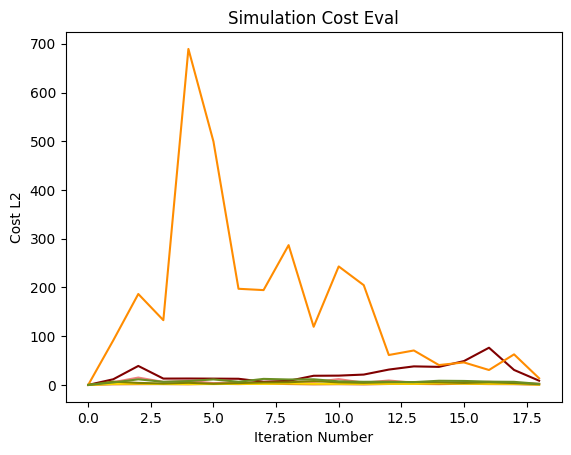

In [15]:
step_indices = list(range(19))
for i in range(first_half):
    plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Cost Eval')
#plt.ylim(0, 70)
plt.show()

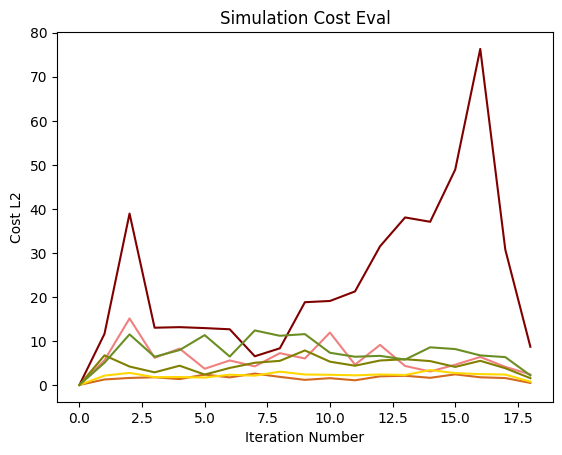

In [16]:
step_indices = list(range(19))
for i in range(first_half):
    if i in [3]:  #(1, 3, 13)
        pass
    else:
        plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Cost Eval')
#plt.ylim(0, 70)
plt.show()

## Compare Scipy.optimize.minimize versions of gradients/Hessians with our analytical vals

In [17]:
first_half = 7

display_info=False
num_updates = 19  # This is 19 for us
dt = 1/60

D = [[0 for _ in range(num_updates)] for i in range(first_half)]
cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
grad_cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]

for idx, user in enumerate(keys[:first_half]):
    filtered_signals = emgs_block1[user][0,:,:]
    p_reference_full = refs_block1[user][0,:,:]
    D[idx][0] = Ws_block1[user][0,0,:,:]
    total_datapoints = emgs_block1[user][0,:,:].shape[0]
    for ix in range(1):
        ix+=1
        lower_bound = update_ix[ix-1]
        if ix==(num_updates-1):
            upper_bound = total_datapoints
        else:
            upper_bound = update_ix[ix]
        learning_batch = upper_bound - lower_bound

        s = np.transpose(filtered_signals[lower_bound:upper_bound,:])
        v_actual = D[idx][ix-1]@s
        p_actual = np.cumsum(v_actual, axis=1)*dt
        p_reference = np.transpose(p_reference_full[lower_bound:upper_bound,:])
        V = (p_reference - p_actual)*dt
        F = copy.deepcopy(s[:,:-1]) # note: truncate F for estimate_decoder
        H = np.zeros((2,2))
        cost_log[idx][ix] = cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        grad_cost_log[idx][ix] = gradient_cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})
        W_hat = np.reshape(out.x,(2, 64))
        W_new = alpha*D[idx][ix-1] + ((1 - alpha) * W_hat)
        D[idx][ix] = W_new

In [18]:
print(F.shape)
print(V.shape)
print(H.shape)

(64, 1199)
(2, 1200)
(2, 2)


In [19]:
# 7 clients by 19 updates I think
D0 = D[0][1]  #D[-1][-1]

From fl_sim_classes.py

In [20]:
out_flsim = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64))

my_out = out_flsim
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.16021748504892613
0.18740478798309046


From 001_Simulations.ipynb

In [21]:
# set up gradient of cost:
# d(c_L2(D))/d(D) = 2*(DF + HV - V+)*F.T + 2*alphaD*D
def gradient_cost_l2_001(F, D, H, V, alphaF=1e-2, alphaD=1e-2):
    Nd = 2
    Ne = 64
    Nt = learning_batch
    D = np.reshape(D,(Nd, Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    return ((2 * (D@F + H@Vminus - Vplus) @ F.T / (Nd*Nt) 
        + 2 * alphaD * D / (Nd*Ne)).flatten())

# set up the cost function: 
# c_L2 = (||DF + HV - V+||_2)^2 + alphaD*(||D||_2)^2 + alphaF*(||F||_2)^2
def cost_l2_001(F, D, H, V, alphaF=1e-2, alphaD=1e-2):
    Nd = 2
    Ne = 64 # default = 64
    Nt = learning_batch
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    e = ( np.sum( (D @ F + H@Vminus - Vplus)**2 ) / (Nd*Nt) 
            + alphaD * np.sum( D**2 ) / (Nd*Ne)
            + alphaF * np.sum( F**2 ) / (Ne*Nt) )
    return e

In [22]:
# This is using different alphas...
out_001_wack = minimize(lambda D: cost_l2_001(F,D,H,V), D0, method='BFGS', jac = lambda D: gradient_cost_l2_001(F,D,H,V))

my_out = out_001_wack
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.21981544716212145
0.29986869696163077


In [23]:
alphaF

1e-07

In [24]:
# Setting the alphas to match condition 0
out_001_c0 = minimize(lambda D: cost_l2_001(F,D,H,V,alphaF=alphaF,alphaD=alphaD), D0, method='BFGS', jac = lambda D: gradient_cost_l2_001(F,D,H,V,alphaF=alphaF,alphaD=alphaD))

my_out = out_001_c0
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.21984074716487884
0.29991571220922203


1. jac
    - Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg, trust-krylov, trust-exact and trust-constr.
    - If None or False, the gradient will be estimated using 2-point finite difference estimation with an absolute step size. Alternatively, the keywords {‘2-point’, ‘3-point’, ‘cs’} can be used to select a finite difference scheme for numerical estimation of the gradient with a relative step size. These finite difference schemes obey any specified bounds.
1. hess
    - Only for Newton-CG, dogleg, trust-ncg, trust-krylov, trust-exact and trust-constr

In [25]:
#scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
#cost_l2(F, D, H, V, learning_batch, alphaF, alphaD)
#scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None)


In [26]:
out_201 = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64))

my_out = out_201
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.16021748504892613
0.18740478798309046


In [27]:
out_nojack_bfgs = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS')

my_out = out_nojack_bfgs
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.16037091000899095
0.18685880254474208


In [28]:
#out_nojack_newtoncg = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='Newton-CG')
# ^ Jacobian is required when using newtoncg
out_jack_newtoncg = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64), D0, method='Newton-CG', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64))

my_out = out_jack_newtoncg
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.16112733293198914
0.18817869789455183


In NB edits to the cost funcs

In [29]:
# set up gradient of cost:
# d(c_L2(D))/d(D) = 2*(DF + HV - V+)*F.T + 2*alphaD*D
def gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, alphaE=1e-6, Nd=2, Ne=64):
    Nt = learning_batch
    D = np.reshape(D,(Nd, Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) #/ (Nd*Nt)
        + 2*alphaD*D ).flatten())  #/ (Nd*Ne)

# set up the cost function: 
# c_L2 = (||DF + HV - V+||_2)^2 + alphaD*(||D||_2)^2 + alphaF*(||F||_2)^2
def cost_l2_no_sq(F, D, H, V, learning_batch, alphaF, alphaD, alphaE=1e-6, Nd=2, Ne=64):
    Nt = learning_batch
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    #term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
    #term2 = alphaD*np.sum(D**2) #/ (Nd*Ne)
    #term3 = alphaF*np.sum(F**2) #/ (Ne*Nt) )
    term1 = (np.linalg.norm((D@F + H@Vminus - Vplus)))*(alphaE)
    term2 = alphaD*(np.linalg.norm(D))
    term3 = alphaF*(np.linalg.norm(F))
    return (term1 + term2 + term3)

# set up the cost function: 
# c_L2 = (||DF + HV - V+||_2)^2 + alphaD*(||D||_2)^2 + alphaF*(||F||_2)^2
def cost_l2_sum_sq(F, D, H, V, learning_batch, alphaF, alphaD, alphaE=1e-6, Nd=2, Ne=64):
    Nt = learning_batch
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
    term2 = alphaD*np.sum(D**2) #/ (Nd*Ne)
    term3 = alphaF*np.sum(F**2) #/ (Ne*Nt) )
    return (term1 + term2 + term3)

In [30]:
out_nojac_bfgs_costnosq = minimize(lambda D: cost_l2_no_sq(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS')

my_out = out_nojac_bfgs_costnosq
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.06467171724715613
0.006131145663262678


In [31]:
out_nojac_bfgs_costsumsq = minimize(lambda D: cost_l2_sum_sq(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS')

my_out = out_nojac_bfgs_costsumsq
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.1601898429800801
0.18735695846991698


In [32]:
out_jac_bfgs_costsumsq = minimize(lambda D: cost_l2_sum_sq(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64))

my_out = out_jac_bfgs_costsumsq
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.1601983872465229
0.1873759730643904


In [33]:
out_jac_bfgs_costsumsq = minimize(lambda D: cost_l2_sum_sq(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=64))

my_out = out_jac_bfgs_costsumsq
print(my_out.x.shape)
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))

(128,)
-0.1601983872465229
0.1873759730643904


## Comparing all the outputs

In [34]:
my_out = out_201
print("out_201")
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))
print()

my_out = out_nojack_bfgs
print("out_nojack_bfgs")
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))
print()

my_out = out_jack_newtoncg
print("out_jack_newtoncg")
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))
print()

my_out = out_nojac_bfgs_costnosq
print("out_nojac_bfgs_costnosq")
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))
print()

my_out = out_nojac_bfgs_costsumsq
print("out_nojac_bfgs_costsumsq")
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))
print()

my_out = out_jac_bfgs_costsumsq
print("out_jac_bfgs_costsumsq")
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))
print()

my_out = out_jac_bfgs_costsumsq
print("out_jac_bfgs_costsumsq")
print(np.sum(my_out.x))
print(np.linalg.norm(my_out.x))
print()

out_201
-0.16021748504892613
0.18740478798309046

out_nojack_bfgs
-0.16037091000899095
0.18685880254474208

out_jack_newtoncg
-0.16112733293198914
0.18817869789455183

out_nojac_bfgs_costnosq
-0.06467171724715613
0.006131145663262678

out_nojac_bfgs_costsumsq
-0.1601898429800801
0.18735695846991698

out_jac_bfgs_costsumsq
-0.1601983872465229
0.1873759730643904

out_jac_bfgs_costsumsq
-0.1601983872465229
0.1873759730643904

